# Setup Dask LOCAL Cluster

In [245]:
CLUSTER_TYPE ="local"
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=local


In [246]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 2GB --nworkers 4 &

fi

In [248]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

from dask.distributed import Client

if CLUSTER_TYPE == "local":
    
    client = Client()

elif CLUSTER_TYPE == "docker_container":
    
    client = Client("{}:8786".format(host_ip))
    
elif CLUSTER_TYPE == "docker_cluster":
    
    # use the provided master
    client = Client("dask-scheduler:8786")
    
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36735,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.35 GiB
Comm: tcp://127.0.0.1:36183,Total threads: 2
Dashboard: http://127.0.0.1:46371/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:40455,


2022-07-02 23:13:18,514 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


# Load data

In [27]:
import dask
import pandas as pd
import numpy as np
from tqdm import tqdm

In [12]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

from dask import delayed

In [17]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

In [21]:
data_folder       = "../data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "real/train/data/raw_data_train_4.npz"

In [22]:
pmt_positions     = pd.read_csv(data_folder+pmt_pos_fname)
pmt_id_conversion = pd.read_csv(data_folder+pmt_id_conv_fname)
conversion_ids = pd.read_csv(data_folder+pmt_id_conv_fname)
# train_data        = np.load(data_folder+train_data_fname, allow_pickle=True)["a"]

# very top but careful about shape
# if it fails to recognize the shape automatically
# we should probably use dask bags
data = dask.delayed(load)(data_folder+train_data_fname).compute()
#data         = da.from_delayed(delayed_data, shape=(3, 5000), dtype=list)

In [14]:
def R_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

def R_x(theta):
    return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

def R_xz(phi,theta):
    return np.matmul(R_x(phi), R_z(theta))

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

In [24]:
@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True)

In [ ]:
def process_one_event(fname):
    
    def load():
        pass
    
    def process():
        pass

    # load 1 data file
    
    # process 1 data file
    
    pass


client.map(process_one_event, fname_list)

In [114]:
Nevents = data.shape[1]

ev_dfs = []

for i in range(Nevents):
    
    nonzeros_inds = da.where(data[2, i] != 0.0)[0]
    ev_id         = dask.delayed(np.repeat)(i, len(nonzeros_inds))
    data_pmt_id   = dask.delayed(convert_pmt_ids)(data[0, i][nonzeros_inds])
    pmt_coord     = dask.delayed(find_pmt_coord)(pmt_positions, data_pmt_id)
    
    tot_charge = dask.delayed(sum)(data[1, i][nonzeros_inds])
    x_cc       = dask.delayed(sum)(pmt_coord["x"] * data[1, i][nonzeros_inds]) / tot_charge
    y_cc       = dask.delayed(sum)(pmt_coord["y"] * data[1, i][nonzeros_inds]) / tot_charge
    z_cc       = dask.delayed(sum)(pmt_coord["z"] * data[1, i][nonzeros_inds]) / tot_charge
    
    theta_cc   = dask.delayed(da.arctan2)(
        dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
    
    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = dask.delayed(da.matmul)(
        dask.delayed(R_yz)(theta_rot, phi_rot), pmt_coord.T
    )
    
    # meta_df = pd.DataFrame(
    #     None, 
    #     columns = ['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new'],
    # )
    # meta_df = meta_df.astype({
    #         "ev_id"  : int,
    #         "pmt_id" : int,
    #         "x"      : float,
    #         "y"      : float,
    #         "z"      : float,
    #         "x_new"  : float,
    #         "y_new"  : float,
    #         "z_new"  : float,
    #         # "charge": float,
    #         # "hit_time": float
    #     })
    # ev_df = dd.from_delayed(
    #     [
    #         ev_id,
    #         data_pmt_id,
    #         pmt_coord["x"],
    #         pmt_coord["y"],
    #         pmt_coord["z"],
    #         coord_new.loc[0],
    #         coord_new.loc[1],
    #         coord_new.loc[2],
    #         # pd.Series(data[1, i][nonzeros_inds]),
    #         # pd.Series(data[2, i][nonzeros_inds])
    #     ],
    #     meta = meta_df,
    #     divisions=(0, 100)
    # )
    # # ev_df["charge"]   = pd.Series(data[1, i][nonzeros_inds])
    # # ev_df["hit_time"] = pd.Series(data[2, i][nonzeros_inds])
    
    # ev_dfs.append(ev_df)


ValueError: divisions should be a tuple of len(dfs) + 1

In [108]:
ev_dfs[0].compute()

distributed.worker - WARNING - Compute Failed
Function:  check_meta
args:      (array([0, 0, 0, ..., 0, 0, 0]), Empty DataFrame
Columns: [ev_id, pmt_id, x, y, z, x_new, y_new, z_new]
Index: [], 'from_delayed')
kwargs:    {}
Exception: "ValueError('Metadata mismatch found in `from_delayed`.\\n\\nExpected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`')"

distributed.worker - WARNING - Compute Failed
Function:  check_meta
args:      (array([    0,     1,     2, ..., 17606, 17608, 17611]), Empty DataFrame
Columns: [ev_id, pmt_id, x, y, z, x_new, y_new, z_new]
Index: [], 'from_delayed')
kwargs:    {}
Exception: "ValueError('Metadata mismatch found in `from_delayed`.\\n\\nExpected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`')"



ValueError: Metadata mismatch found in `from_delayed`.

Expected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`

In [78]:
a = coord_new.compute()

distributed.utils - ERROR - 'matmul'
Traceback (most recent call last):
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/distributed/utils.py", line 695, in log_errors
    yield
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2300, in update_layout
    order = dask.order.order(
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/dask/order.py", line 116, in order
    metrics = graph_metrics(dependencies, dependents, total_dependencies)
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/dask/order.py", line 886, in graph_metrics
    val = total_dependencies[key]
KeyError: 'matmul'
bokeh.util.tornado - ERROR - Error thrown from periodic callback:
bokeh.util.tornado - ERROR - Traceback (most recent call last):
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/tornado/gen.py", line 526, in callback
    result_list.append(f.result())
  File "/Users/niklai/miniforge3/lib/python3.9/site

bokeh.util.tornado - ERROR - Error thrown from periodic callback:
bokeh.util.tornado - ERROR - Traceback (most recent call last):
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/tornado/gen.py", line 526, in callback
    result_list.append(f.result())
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/bokeh/server/session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/bokeh/server/session.py", line 195, in with_document_locked
    return func(*args, **kwargs)
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/bokeh/document/document.py", line 1212, in wrapper
    return doc._with_self_as_curdoc(invoke)
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/bokeh/document/document.py", line 1198, in _with_self_as_curdoc
    return f()
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/bokeh/document/document.py", line 1211, in invoke
    r

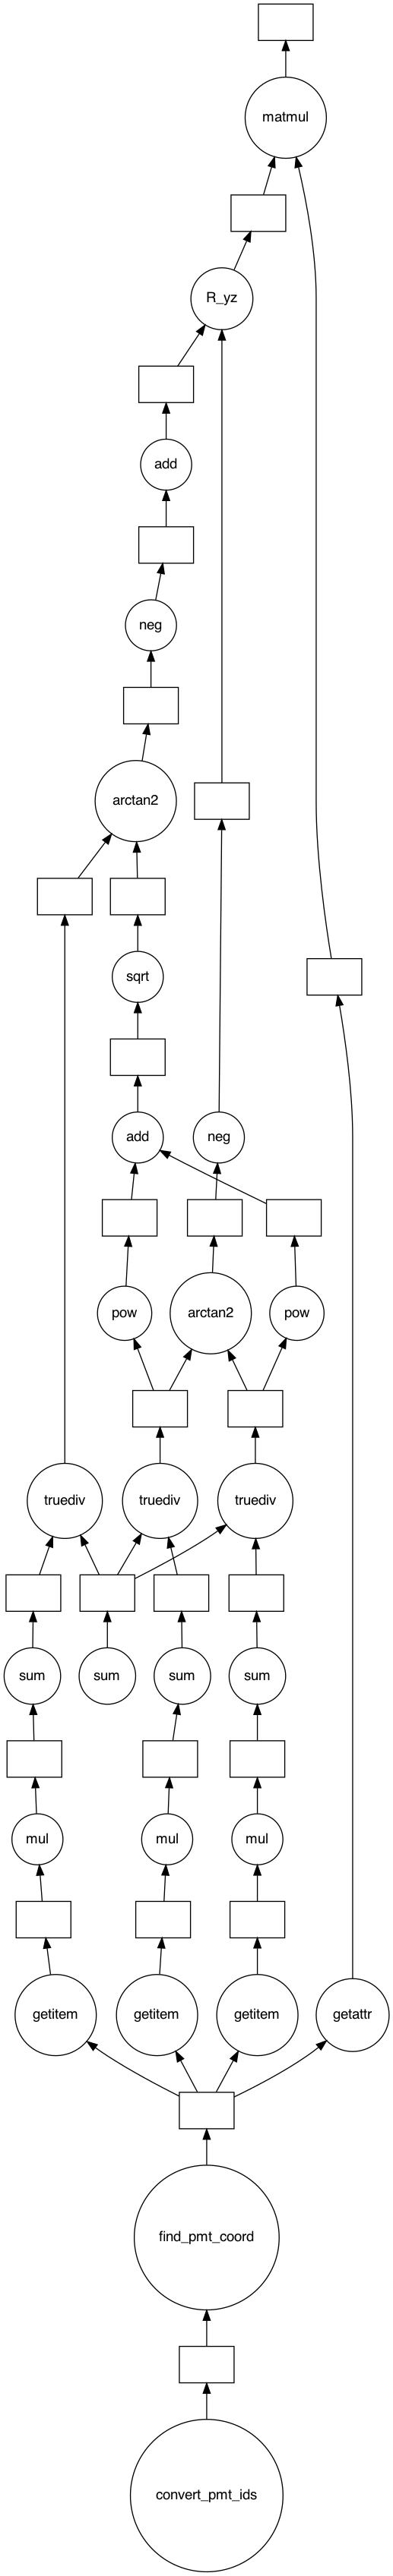

In [68]:
coord_new.visualize()

In [51]:
data_pmt_id.compute()

array([    1,     3,     5, ..., 17603, 17604, 17606])

In [47]:
arrays = [
    da.from_delayed(ev, shape=)
    for ev in pmt_coords
]

AttributeError: 'list' object has no attribute 'key'

Invece di fare il for loop su gli Nevents facciamo una funzione e usiamo map

In [103]:
def map_pmt(data):
    return list(map(convert_pmt_ids, data[0]))

def convert_id_data(data, pmt_id):
    return np.concatenate((pmt_id, data[1], data[2]), axis=1)

In [104]:
asd = dask.delayed(convert_id_data)(data, dask.delayed(map_pmt)(data))

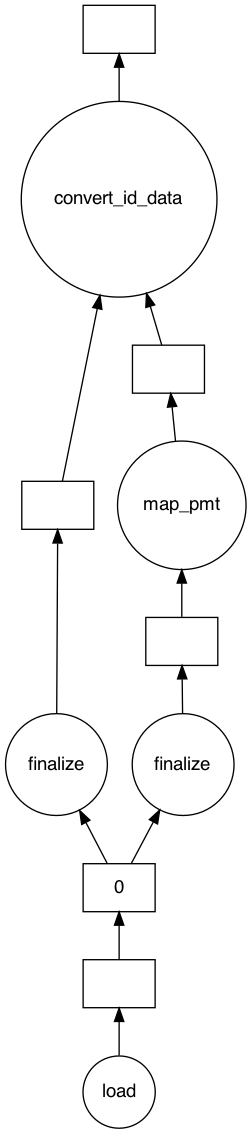

In [106]:
asd.visualize()

In [105]:
asd.compute()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
distributed.worker - WARNING - Compute Failed
Function:  convert_id_data
args:      (array([[array([268435456, 268435712, 268435968, ..., 272942592, 272943104,
               272943872])                                                ,
        array([268435456, 268435712, 268435968, ..., 272941312, 272941568,
               272942592])                                                ,
        array([268439808, 268440576, 268442368, ..., 272941312, 272942336,
               272943872])                                                ,
        ...,
        array([268435456, 268436224, 268438528, ..., 272941824, 272942592,
               272942848])                                                

AxisError: axis 1 is out of bounds for array of dimension 1

In [99]:
data.compute()[1:, :]

array([[array([1.01690963, 1.28989536, 1.45731761, ..., 0.84074667, 0.62002294,
               0.54371369])                                                    ,
        array([7.69295221, 6.3163542 , 1.64953939, ..., 0.96302451, 1.00156736,
               5.64844231])                                                    ,
        array([1.07703118, 1.44051909, 1.11252405, ..., 0.90081651, 1.31535002,
               0.65504042])                                                    ,
        ...,
        array([1.07258583, 1.1564229 , 1.02084184, ..., 0.97048609, 1.381067  ,
               0.64550814])                                                    ,
        array([1.15841609, 0.90353737, 0.98455776, ..., 4.60548049, 1.14924478,
               2.36119674])                                                    ,
        array([0.32972067, 1.56554185, 2.23426315, ..., 0.84995849, 1.00597237,
               1.72392145])                                                    ],
       [array([278.5

In [126]:
def map_pmt(data):
    def single_map(data):
        id_list = convert_pmt_ids(data[0])
        return np.vstack((id_list, data[1], data[2]))
    
    mapped_events_dlyd = []
    for i in range(data.shape[1]):
        mapped_events_dlyd.append(dask.delayed(single_map)(data[:, i]))
        
    # print(len(mapped_events_dlyd))    
    return mapped_events_dlyd

In [145]:
dlyd_list = dask.delayed(map_pmt)(data)

In [149]:
dlyd_list

Delayed('map_pmt-4a33e258-ba17-4db6-b5cb-de1f3ed762be')

In [152]:
arrr = da.from_delayed(dlyd_list, dtype=list, shape=1)


TypeError: object of type 'int' has no len()

In [143]:
da.stack(arrr, axis = 0).compute()

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function getitem at 0x12740d820>, (<function map_pmt at 0x110904af0>, (<function finalize at 0x1273a0c10>, [(<function load at 0x12763f9d0>, '../data/raw_data_train_4.npz')])), (None, slice(None, None, None), slice(None, None, None))))
kwargs:    {}
Exception: "TypeError('list indices must be integers or slices, not tuple')"



TypeError: list indices must be integers or slices, not tuple

In [137]:
len(dlyd_list.compute())

5000

In [140]:
dlyd_list.compute()[0].compute().shape

(3, 4346)

# Distributed Mapping

In [249]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

In [250]:
data_folder       = "../data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "real/train/data/raw_data_train_4.npz"

In [251]:
pmt_positions     = pd.read_csv(data_folder+pmt_pos_fname)
pmt_id_conversion = pd.read_csv(data_folder+pmt_id_conv_fname)
conversion_ids    = pd.read_csv(data_folder+pmt_id_conv_fname)
# train_data        = np.load(data_folder+train_data_fname, allow_pickle=True)["a"]

# very top but careful about shape
# if it fails to recognize the shape automatically
# we should probably use dask bags
data = dask.delayed(load)(data_folder+train_data_fname).compute()
#data         = da.from_delayed(delayed_data, shape=(3, 5000), dtype=list)

In [252]:
def R_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

def R_x(theta):
    return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

def R_xz(phi,theta):
    return np.matmul(R_x(phi), R_z(theta))

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

In [253]:
@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

In [254]:
#R = 19387.6557
Nevents = 1#data.shape[1]

images_mat = da.zeros(shape=(Nevents, 124, 230, 2))
N_max = 115

error_ls = []
for i in tqdm(range(Nevents)):
    # find non-zero-time hits

    nonzeros_inds = da.where(data[2, i] != 0.0)[0]
    data_pmt_id   = convert_pmt_ids(data[0, i][nonzeros_inds], conversion_ids)
    pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)
    
    tot_charge = dask.delayed(sum)(data[1, i][nonzeros_inds])
    x_cc       = dask.delayed(sum)(pmt_coord[:,0] * data[1, i][nonzeros_inds]) / tot_charge
    y_cc       = dask.delayed(sum)(pmt_coord[:,1] * data[1, i][nonzeros_inds]) / tot_charge
    z_cc       = dask.delayed(sum)(pmt_coord[:,2] * data[1, i][nonzeros_inds]) / tot_charge
    
    theta_cc   = dask.delayed(da.arctan2)(
        dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
    
    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = dask.delayed(da.matmul)(
        R_yz(theta_rot, phi_rot), pmt_coord.T
    )

    Rs = dask.delayed(da.sqrt)(dask.delayed(da.sum)(coord_new**2, axis=0))

    charge_hitt = da.array([data[1, i][nonzeros_inds], 
                            data[2, i][nonzeros_inds]]).T
    ####################
    '''
    ev_df['x_new'] = coord_new.loc[0]
    ev_df['y_new'] = coord_new.loc[1]
    ev_df['z_new'] = coord_new.loc[2]
    ev_df['R']     = np.sqrt(coord_new.loc[0]**2 + coord_new.loc[1]**2 + coord_new.loc[2]**2)
 
       
    ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
    ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])
    '''
    
    '''
    MAPPING
    '''
    coord_new = coord_new.compute()#.persist()
    errors = 0
    z_levels, step = da.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    image_rows = []
    for j, z in enumerate(z_levels):
        mask = (da.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
        if(not da.any(mask)): continue
        masked = coord_new[:,mask]
        
        R = Rs[mask].mean().compute()
        
        Rz = (R**2 - z**2)
        if Rz < 0:
            Neff = 0
            errors = errors + 1
        else:
            Neff = N_max * da.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = da.around( Neff * (da.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        ix = ix.compute()
        if(da.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230
        
        image_rows.append(charge_hitt[ix, ])

        # if np.isnan(mat[ix, i+1]):
        #     mat[ix, i+1] = row.id
        # else:
        #     mat[ix, 123 if i else i] = row.id

    
    error_ls.append(errors)
    

    

100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


In [229]:
charge_hitt[ix,]

dask.array<getitem, shape=(27, 2), dtype=float64, chunksize=(27, 2), chunktype=numpy.ndarray>

In [237]:
result= client.map(dask.compute, image_rows)

In [241]:
result = client.gather(result)

In [244]:
result[0]

(array([[4.23560228e-01, 2.45133843e+02],
        [4.23560228e-01, 2.45133843e+02],
        [6.20277354e-01, 7.67124823e+02],
        [4.23560228e-01, 2.45133843e+02],
        [6.20277354e-01, 7.67124823e+02],
        [6.20277354e-01, 7.67124823e+02],
        [6.20277354e-01, 7.67124823e+02],
        [6.20277354e-01, 7.67124823e+02],
        [6.20277354e-01, 7.67124823e+02],
        [4.23560228e-01, 2.45133843e+02],
        [6.20277354e-01, 7.67124823e+02],
        [1.23054884e+00, 2.67351823e+02],
        [4.23560228e-01, 2.45133843e+02],
        [6.20277354e-01, 7.67124823e+02],
        [1.02837359e+00, 2.39566129e+02],
        [1.23054884e+00, 2.67351823e+02],
        [1.23054884e+00, 2.67351823e+02],
        [1.23054884e+00, 2.67351823e+02],
        [1.23054884e+00, 2.67351823e+02],
        [1.02837359e+00, 2.39566129e+02],
        [1.23054884e+00, 2.67351823e+02],
        [1.02837359e+00, 2.39566129e+02],
        [1.02837359e+00, 2.39566129e+02],
        [1.02837359e+00, 2.3956612

In [184]:
if(da.any(ix>=115)):
    ix[ix>=115] -= 230
ix.compute()

2022-07-02 22:37:51,491 - distributed.worker - WARNING - Compute Failed
Key:       ('getitem-where-f18f6f30183bf616fc4a6f849ef60c1b', 0)
Function:  execute_task
args:      ((subgraph_callable-7730e32a-98fb-4f09-898a-40ab031e93a9, array([ True,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False,  True, False,  True,  True,  True, False, False,  True]), array([116, 116, 113, 116, 113, 113, 113, 113, 113, 116, 113, 114, 116,
       113, 115, 114, 114, 114, 114, 115, 114, 115, 115, 115, 114, 114,
       115], dtype=int32), (subgraph_callable-8a2c9984-b85f-482b-bfd7-8f68b07af19e, array([116, 116, 113, 116, 113, 113, 113, 113, 113, 116, 113, 114, 116,
       113, 115, 114, 114, 114, 114, 115, 114, 115, 115, 115, 114, 114,
       115], dtype=int32), array([ True,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False,  True

ValueError: operands could not be broadcast together with shapes (27,) (11,) (27,) 

In [141]:
images_mat[0,0,[0, 1, 2, 3],]

dask.array<getitem, shape=(4, 2), dtype=float64, chunksize=(4, 2), chunktype=numpy.ndarray>

In [114]:
corr_mask = da.where(ix.compute() >= 230)

In [82]:
R = dask.delayed(da.sqrt)(dask.delayed(da.sum)(coord_new**2, axis=0))

In [85]:
R[[1, 2, 3, 4]].compute().compute()

array([19387.65571113, 19387.65571097, 19414.46792994, 19414.46793342])

In [146]:
phi_cc.compute()

-2.333672324094869

In [247]:
client.shutdown()